# scRNA-Seq pre-processing

Pre-processing pipleine with scanpy

In [1]:

import os 
import pandas as pd
import numpy as np
import scanpy as sc
import scipy as sci
import matplotlib.pyplot as plt
import anndata as ad

In [2]:
# Read features
url = 'https://raw.githubusercontent.com/jamesfread/scRNAseq_Preprocessing/main/Data/Donor2_5yr_Unstim_features.tsv'
ft = pd.read_csv(url, sep='\t', header=None)

# Read barcodes
url = "https://raw.githubusercontent.com/jamesfread/scRNAseq_Preprocessing/main/Data/Donor2_5yr_Unstim_barcodes.tsv"
bc = pd.read_csv(url, sep='\t', header=None)

mat = sc.read_mtx('Data/Donor2_5yr_Unstim_matrix.mtx')
print(mat)
mat = ad.AnnData.transpose(mat)
print(mat)




AnnData object with n_obs × n_vars = 36601 × 1482511
AnnData object with n_obs × n_vars = 1482511 × 36601


Check data

In [3]:
print(ft.head(5))
print(bc.head(5))
mat

                 0            1                2
0  ENSG00000243485  MIR1302-2HG  Gene Expression
1  ENSG00000237613      FAM138A  Gene Expression
2  ENSG00000186092        OR4F5  Gene Expression
3  ENSG00000238009   AL627309.1  Gene Expression
4  ENSG00000239945   AL627309.3  Gene Expression
                    0
0  AAACCCAAGAAACACT-1
1  AAACCCAAGAAACCCA-1
2  AAACCCAAGAAACCCG-1
3  AAACCCAAGAAACCTG-1
4  AAACCCAAGAAACTAC-1


AnnData object with n_obs × n_vars = 1482511 × 36601

Add column names

In [4]:
# Add column names
ft.columns = ["ENSEMBLID", "Gene", "Type"]
bc.columns = ["Barcode"]
print(ft.head(5))

         ENSEMBLID         Gene             Type
0  ENSG00000243485  MIR1302-2HG  Gene Expression
1  ENSG00000237613      FAM138A  Gene Expression
2  ENSG00000186092        OR4F5  Gene Expression
3  ENSG00000238009   AL627309.1  Gene Expression
4  ENSG00000239945   AL627309.3  Gene Expression


Add barcode and gene names to anndata object

In [5]:
print(ft.shape[0]) 
print(bc.shape[0])
print(mat.shape[0]); print(mat.shape[1]) 

36601
1482511
1482511
36601


In [6]:
mat.obs_names = bc["Barcode"]
mat.var_names = ft["ENSEMBLID"]
print(mat.obs_names[:10])
print(mat.var_names[:10])
print(mat)

Index(['AAACCCAAGAAACACT-1', 'AAACCCAAGAAACCCA-1', 'AAACCCAAGAAACCCG-1',
       'AAACCCAAGAAACCTG-1', 'AAACCCAAGAAACTAC-1', 'AAACCCAAGAAACTGT-1',
       'AAACCCAAGAAAGCGA-1', 'AAACCCAAGAAATTGC-1', 'AAACCCAAGAACAGGA-1',
       'AAACCCAAGAACCCGA-1'],
      dtype='object', name='Barcode')
Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906',
       'ENSG00000241860', 'ENSG00000241599', 'ENSG00000286448',
       'ENSG00000236601'],
      dtype='object', name='ENSEMBLID')
AnnData object with n_obs × n_vars = 1482511 × 36601


Make unique var names

In [249]:

# Check duplicates
#print(mat.var_names.duplicated().any())
#mat.var_names_make_unique()
# Recheck duplicates
#print(mat.var_names.duplicated().any())

Next, will need to remove cells with only ambient RNA levels. 

In [7]:
cutoff1 =  100; cutoff2 =  200; cutoff3 =  500; cutoff4 =  1000
knee = np.sort((np.array(mat.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))

Show the number of cell for each threshold

In [9]:
set = [cutoff1, cutoff2, cutoff3, cutoff4]

# access elements of the list one by one
for i in set:
    if i == 100: j = "100 UMIs"; 
    if i == 200: j = "200 UMIs";
    if i == 500: j = "500 UMIs";
    if i == 1000: j = "1000 UMIs"
    
    print(j, " = ", cell_set[knee > i][::-1][0])

100 UMIs  =  7767
200 UMIs  =  6832
500 UMIs  =  6450
1000 UMIs  =  6304


Plot the elbow plot

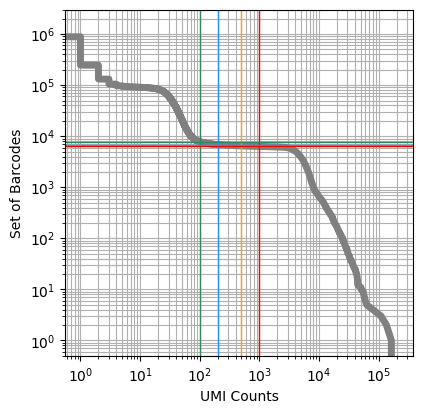

In [12]:
fig, ax = plt.subplots(figsize=(4.5, 4.5))

ax.loglog(knee, cell_set, linewidth=5, color="grey")
ax.axvline(x=cutoff1, linewidth=1, color="seagreen")
ax.axvline(x=cutoff2, linewidth=1, color="dodgerblue")
ax.axvline(x=cutoff3, linewidth=1, color="orange")
ax.axvline(x=cutoff4, linewidth=1, color="red")

ax.axhline(y=cell_set[knee > cutoff1][::-1][0], linewidth=1, color="seagreen")
ax.axhline(y=cell_set[knee > cutoff2][::-1][0], linewidth=1, color="dodgerblue")
ax.axhline(y=cell_set[knee > cutoff3][::-1][0], linewidth=1, color="orange")
ax.axhline(y=cell_set[knee > cutoff4][::-1][0], linewidth=1, color="red")


ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

Make cutoff 200

In [14]:
expected_num_cells = cell_set[knee > cutoff2][::-1][0]

expected_num_cells

6832

In [15]:
# Filter the cells according to the threshold determined from the knee plot
mat2 = mat.copy()
#sc.pp.filter_cells(mat2, min_genes=cutoff3)
sc.pp.filter_cells(mat2, min_counts=knee[expected_num_cells])

print(mat)
print(mat2)

AnnData object with n_obs × n_vars = 1482511 × 36601
AnnData object with n_obs × n_vars = 6833 × 36601
    obs: 'n_counts'


In [18]:
print(mat2.obs_names[:10])
print(mat2.var_names[:10])

Index(['AAACCCAAGAAACACT-1', 'AAACCCAAGCGTTCAT-1', 'AAACCCACATCCAATG-1',
       'AAACCCACATCGAACT-1', 'AAACCCAGTAACGATA-1', 'AAACCCAGTCGCTCGA-1',
       'AAACCCAGTGTGCCTG-1', 'AAACCCATCCAATGCA-1', 'AAACGAACACCAGGTC-1',
       'AAACGAACATAGGTAA-1'],
      dtype='object', name='Barcode')
Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906',
       'ENSG00000241860', 'ENSG00000241599', 'ENSG00000286448',
       'ENSG00000236601'],
      dtype='object', name='ENSEMBLID')


Filter out by mitochondrial content

In [17]:
mito_ensembl_ids = sc.queries.mitochondrial_genes("hsapiens", attrname="ensembl_gene_id")

In [19]:
mito_genes = mito_ensembl_ids["ensembl_gene_id"].values

print(mito_genes)
print(type(mito_genes))

# Convert to list
mito_genes2 = mito_genes.tolist()

print(type(mito_genes2))
print(mito_genes2)

['ENSG00000210049' 'ENSG00000211459' 'ENSG00000210077' 'ENSG00000210082'
 'ENSG00000209082' 'ENSG00000198888' 'ENSG00000210100' 'ENSG00000210107'
 'ENSG00000210112' 'ENSG00000198763' 'ENSG00000210117' 'ENSG00000210127'
 'ENSG00000210135' 'ENSG00000210140' 'ENSG00000210144' 'ENSG00000198804'
 'ENSG00000210151' 'ENSG00000210154' 'ENSG00000198712' 'ENSG00000210156'
 'ENSG00000228253' 'ENSG00000198899' 'ENSG00000198938' 'ENSG00000210164'
 'ENSG00000198840' 'ENSG00000210174' 'ENSG00000212907' 'ENSG00000198886'
 'ENSG00000210176' 'ENSG00000210184' 'ENSG00000210191' 'ENSG00000198786'
 'ENSG00000198695' 'ENSG00000210194' 'ENSG00000198727' 'ENSG00000210195'
 'ENSG00000210196']
<class 'numpy.ndarray'>
<class 'list'>
['ENSG00000210049', 'ENSG00000211459', 'ENSG00000210077', 'ENSG00000210082', 'ENSG00000209082', 'ENSG00000198888', 'ENSG00000210100', 'ENSG00000210107', 'ENSG00000210112', 'ENSG00000198763', 'ENSG00000210117', 'ENSG00000210127', 'ENSG00000210135', 'ENSG00000210140', 'ENSG00000210144'

In [20]:

## Confirm EnsemblIDs are in there


# See number of mitochondrial gene-related EnsemblID's
print(len(mito_genes2))
print(mito_genes2)

# Check if characters exist in the variable names using list comprehension
result = [char in mat2.var_names for char in mito_genes2]
result2 = [not(char in mat2.var_names) for char in mito_genes2]
print(result)
print(result2)


37
['ENSG00000210049', 'ENSG00000211459', 'ENSG00000210077', 'ENSG00000210082', 'ENSG00000209082', 'ENSG00000198888', 'ENSG00000210100', 'ENSG00000210107', 'ENSG00000210112', 'ENSG00000198763', 'ENSG00000210117', 'ENSG00000210127', 'ENSG00000210135', 'ENSG00000210140', 'ENSG00000210144', 'ENSG00000198804', 'ENSG00000210151', 'ENSG00000210154', 'ENSG00000198712', 'ENSG00000210156', 'ENSG00000228253', 'ENSG00000198899', 'ENSG00000198938', 'ENSG00000210164', 'ENSG00000198840', 'ENSG00000210174', 'ENSG00000212907', 'ENSG00000198886', 'ENSG00000210176', 'ENSG00000210184', 'ENSG00000210191', 'ENSG00000198786', 'ENSG00000198695', 'ENSG00000210194', 'ENSG00000198727', 'ENSG00000210195', 'ENSG00000210196']
[False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, True, False, False, True, False, True, True, True, False, True, False, True, True, False, False, False, True, True, False, True, False, False]
[True, True, True, True, True, False, True, Tr

Retain only mito_genes which exist in data set

In [21]:

from itertools import compress

mito_genes3 = list(compress(mito_genes2, result))

# Retain only mito_genes which exist in data set
# mito_genes3 = [char for char, exists in zip(mito_genes2, mat2.var_names) if exists]
print(len(mito_genes3))

print([char in mat2.var_names for char in mito_genes3])


13
[True, True, True, True, True, True, True, True, True, True, True, True, True]


In [23]:
# for each cell compute fraction of counts in mito genes vs. all genes

mat2.obs['percent_mito'] = np.sum(
    mat2[:, mito_genes3].X, axis=1).A1 / np.sum(mat2.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
mat2.obs['n_counts'] = mat2.X.sum(axis=1).A1


# ribosomal genes
mat2.var["ribo"] = mat2.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
mat2.var["hb"] = mat2.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(mat2, qc_vars=["ribo", "hb"], inplace=True, log1p=True)


Plot

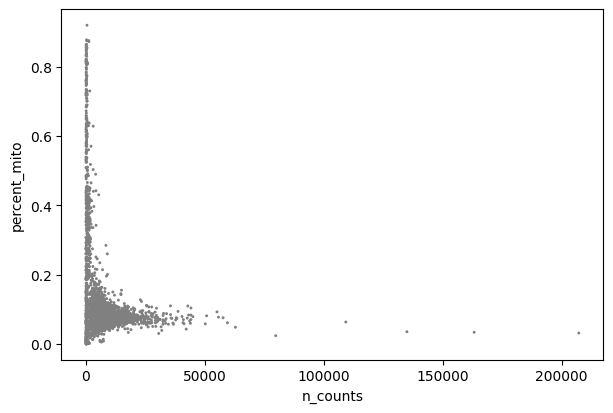

In [41]:
sc.pl.scatter(mat2, x='n_counts', y='percent_mito')

ax.axhline(y=0.2, linewidth=1, color="red") # Add this line

fff

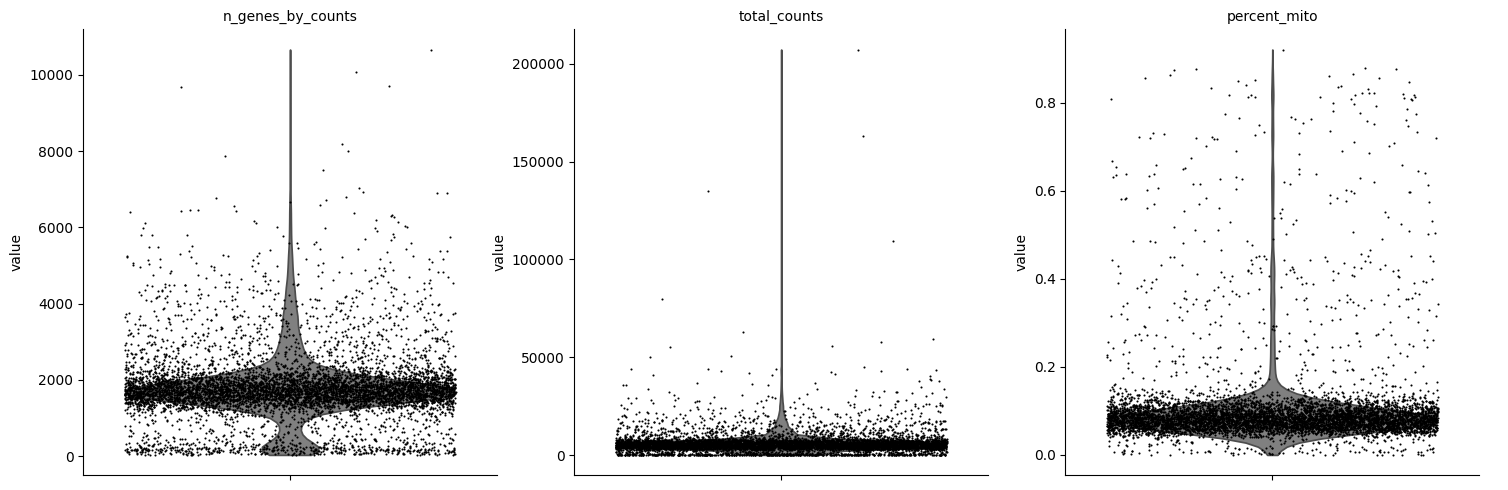

In [33]:
sc.pl.violin(mat2, ["n_genes_by_counts", "total_counts", "percent_mito"],
    jitter=0.4, multi_panel=True, size = 1.5, color = "grey")

rrr

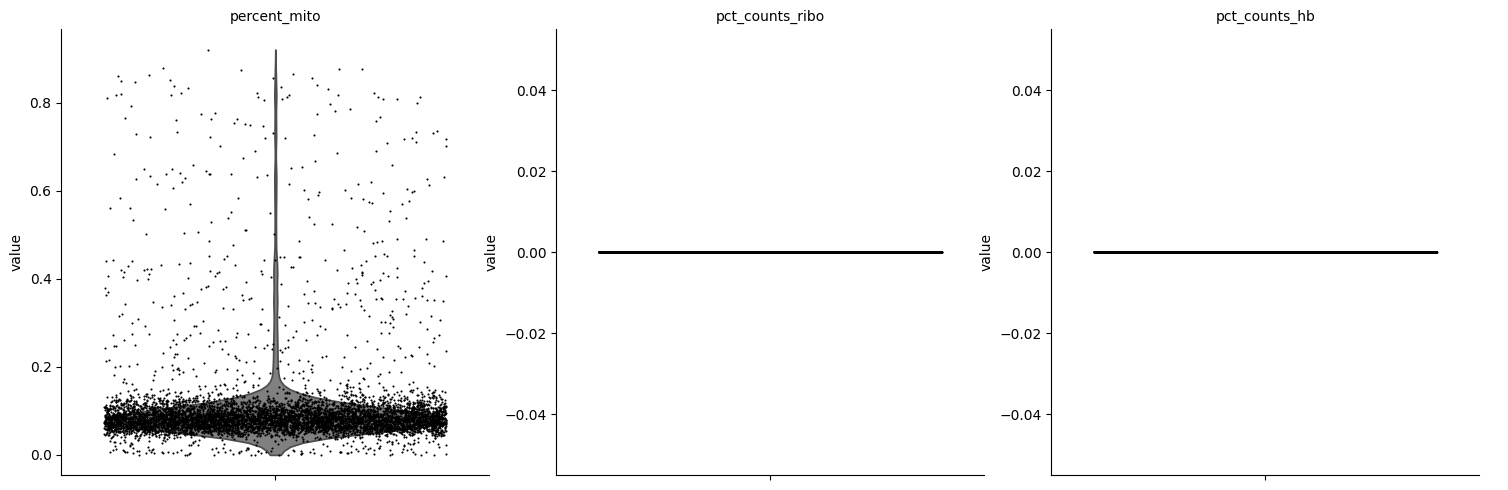

In [34]:
sc.pl.violin(mat2, ["percent_mito", "pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4, multi_panel=True, size = 1.5, color = "grey")

ggg

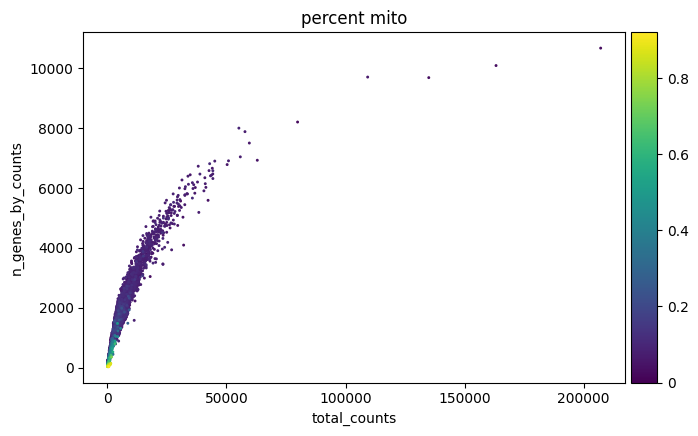

In [36]:
sc.pl.scatter(mat2, "total_counts", "n_genes_by_counts", color="percent_mito")

Filter out cell with > 20% mitochondrial gene content

In [37]:
mat2 = mat2[mat2.obs.percent_mito < 0.2]

In [38]:
mat2

View of AnnData object with n_obs × n_vars = 6436 × 36601
    obs: 'n_counts', 'percent_mito', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

Other cell filters

In [39]:
sc.pp.filter_cells(mat2, min_genes=100)


c:\Users\jread\AppData\Local\anaconda3\envs\scRNAseq_py3_11\Lib\site-packages\scanpy\preprocessing\_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


In [40]:
mat2

AnnData object with n_obs × n_vars = 6435 × 20746
    obs: 'n_counts', 'percent_mito', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

Now filter out genes...

In [ ]:
sc.pp.filter_genes(adata, min_cells=3)

Continue here:
https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html

https://www.kallistobus.tools/tutorials/kb_getting_started/python/kb_intro_2_python/
